# New calibrator algorithm

This tests out the new calibrator detection algorithm with proper timing and everything.

In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from scipy.interpolate import interp1d
sys.path.append('BNL/jupyter/notebooks/calibrator')
os.environ['LUSEE_DRIVE_DIR']='drive/'
from algorithms import  Comb, Calibrator


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# pip install fitsio

In [13]:
# load in luseepy
current_dir = os.getcwd()

# Get the path to BNL/jupyter directory
jupyter_dir = os.path.abspath(os.path.join(current_dir, '../..'))
# Append the jupyter directory to the system path
sys.path.append(jupyter_dir)

import luseepy
from luseepy import lusee


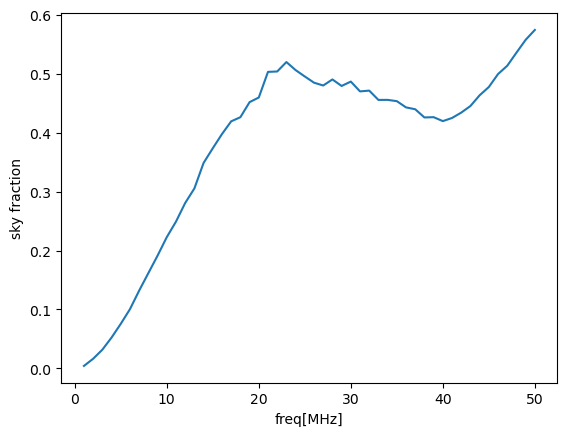

In [14]:
B=lusee.Beam()
plt.plot(B.freq,B.sky_fraction()) # frequency list, fraction of beam power that terminates on the sky
plt.xlabel('freq[MHz]')
plt.ylabel('sky fraction')
sky_fraction = interp1d(B.freq,B.sky_fraction(),kind='linear') # function of sky brightness by frequency




Text(0, 0.5, 'sky brightness [W/m^2/Hz/sr]')

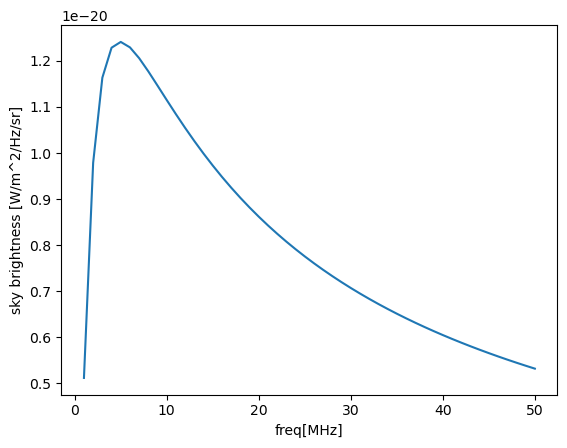

In [15]:
plt.plot(B.freq,lusee.MonoSkyModels.B_NB(B.freq)) # sky brightness at observing frequencies
plt.xlabel('freq[MHz]')
plt.ylabel('sky brightness [W/m^2/Hz/sr]')

Power per tone 1e-17 W/m^2


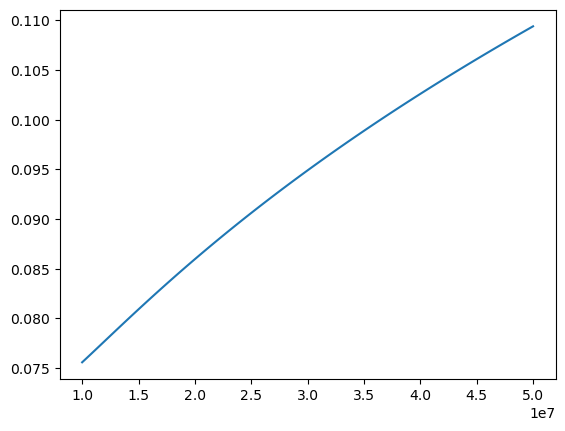

In [16]:
# define signal and sky signals
req_level = 1e-22 * 100e3 ## Appendix A requirement W/m^2 /Hz * 100kHz

print ("Power per tone",req_level,'W/m^2')

# find signal
def signal_rms(freq):
    freq_MHz = freq/1e6 # scale to MHz
    sf = sky_fraction(freq_MHz) 
    return np.sqrt(req_level*sf) # signal

# find noise
def noise_rms(freq):
    freq_MHz = freq/1e6
    channel_width = 25e3 ## 25kHz primary channelization
    sf = sky_fraction(freq_MHz)
    sky_area = 2*np.pi
    sky_signal =  lusee.MonoSkyModels.B_NB(freq_MHz)*sf*channel_width*sky_area # sky brightness scaled
    return np.sqrt(sky_signal) # total sky brightness (ie noise)


# plot signal to noise
freq=np.linspace(10e6,50e6,100)
plt.plot(freq,signal_rms(freq)/noise_rms(freq))
#plt.plot(freq,noise(freq))

In [17]:
comb=Comb(Nstart= 181, Nend= 983, response=signal_rms, noise=noise_rms) # define a frequency comb
C = Calibrator(comb, alpha=-0.3,dalpha_dt=0.0, add_noise=True, Nnotch=16, Nintg=64) # establist calibrator object
#C.produce_data_block()[:,0]
res = C.analyze_data(alpha_start=0.4,tmax=20) # get analysis
res['detect'], res['SNRdBdet'] # if S/N > 1.5 and drift small enough, S/N in db

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

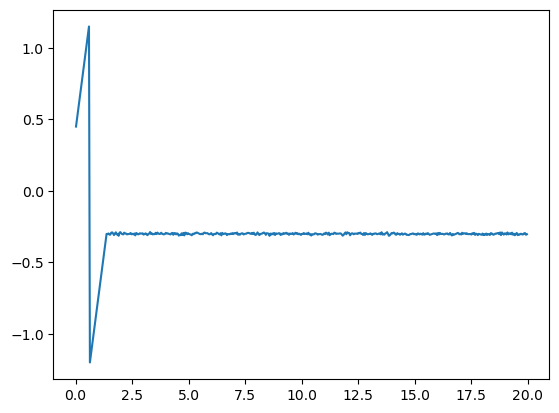

In [18]:
plt.plot(res['t'], res['alphadet']) # time vs how much phase change changes

#plt.xlim(0,1)

In [19]:
# new comb and calibrator objects
comb=Comb(response=signal_rms, noise=noise_rms)
C = Calibrator(comb, alpha=-0.4,dalpha_dt=0.0, add_noise=True, Nnotch=256, Nintg=4)
wb,nb = C.analyze_data_incoherent()

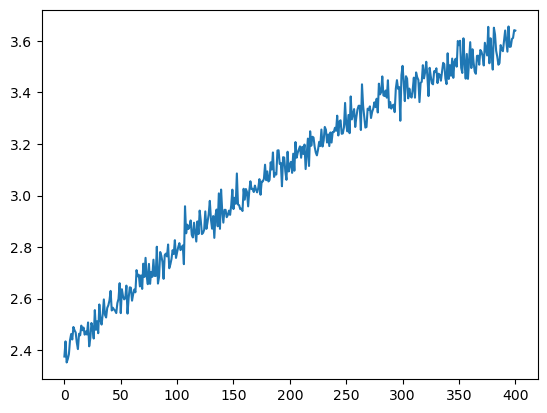

In [20]:
plt.plot(nb/wb) # narrow/wide bins, narrow should minimize noise
